# 하이퍼 파라미터 튜닝

`keras-tuner` 패키지의 설치가 필요하다.

```shell
pip install --upgrade keras-tuner
```

## #01. 준비작업

### [1] 패키지 가져오기


In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

from datetime import datetime as dt
from kerastuner import Hyperband

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import (
    History,
    EarlyStopping,
    ReduceLROnPlateau,
)

from tensorflow.keras.optimizers import Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터셋 준비하기


In [3]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx", info=False)


상위 5개 행
+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


## #02. 데이터 전처리

### [1] 데이터 스케일링


In [4]:
df = my_minmax_scaler(data=origin, yname='무게')
my_pretty_table(df.head())

+----+----------+----------+-----------+--------+
|    |     길이 |     높이 |      두께 |   무게 |
|----+----------+----------+-----------+--------|
|  0 |        0 |        0 |         0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 |     70 |
+----+----------+----------+-----------+--------+


### [2] 훈련/검증 데이터 분할


In [5]:
x_train, x_test, y_train, y_test = my_train_test_split(df, '무게')
rows, cols = x_train.shape

## #03. 하이퍼파라미터 튜닝

### [1] 훈련 모델 적합

튜닝할 파라미터를 설정하는 콜백함수를 정의해야 한다. (람다식 불가~!!!)

In [7]:
def tf_build(hp) -> Sequential:
    model = Sequential()
    
    model.add(
        Dense(
            units=hp.Choice('units', values=[32, 64, 128]),
            activation='relu',
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice('units', values=[16, 32, 64]),
            activation='relu',
                    )
    )
    model.add(Dense(1, activation='linear'))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'],
    )
    
    return model



### [2] 튜너를 인스턴스화하고 하이퍼튜닝 수행하기

튜너를 인스턴스화하여 하이퍼튜닝을 수행한다.

Keras Tuner에는 RandomSearch, Hyperband, BayesianOptimization 및 Sklearn의 네 가지 튜너가 있다.

Hyperband 튜너를 인스턴스화하려면 최적화할 하이퍼모델인 objective, 및 훈련할 최대 epoch 수(max_epochs)를 지정해야 한다.

Hyperband 튜닝 알고리즘은 적응형 리소스 할당 및 조기 중단을 사용하여 고성능 모델에서 신속하게 수렴한다.

이 알고리즘은 몇 개의 epoch에 대해 많은 수의 모델을 훈련하고 최고 성능을 보이는 절반만 다음 단계로 넘긴다.

Hyperband는 `1 + logfactor( max_epochs)` 를 계산하고 이를 가장 가까운 정수로 반올림하여 한 브래킷에서 훈련할 모델 수를 결정한다.

> Li, Lisha, and Kevin Jamieson. ["Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization." Journal of Machine Learning Research 18 (2018): 1-52](http://jmlr.org/papers/v18/16-558.html)


In [9]:
tuner = Hyperband(
    hypermodel = tf_build,
    objective='val_mae',
    max_epochs=10,
    factor=3,
    seed= get_random_state(),
    directory='D:\\tensor_hyperband',
    project_name = 'tf_hyperband_%s' % dt.now().strftime('%Y%m%d%H%M%S')
)
tuner

In [10]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError('No best hyperparameters found')
print(
    f"""
    The hyperparameter search is complete. The optimal numberof units in the first densely-connected
    layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer is {best_hps[0].get('learning_rate')}.
    """
)


Trial 9 Complete [00h 00m 02s]
val_mae: 348.40234375

Best val_mae So Far: 346.73583984375
Total elapsed time: 00h 00m 16s

    The hyperparameter search is complete. The optimal numberof units in the first densely-connected
    layer is 128 and the optimal learning rate for the optimizer is 0.01.
    


### [3] 학습 및 결과 평가

도출된 하이퍼 파라미터가 적용된 새로운 모델을 생성하고, 학습을 별도로 수행해야 한다.

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 55456.6 |  213.33 |
| test  | 27993.5 | 163.325 |
+-------+---------+---------+


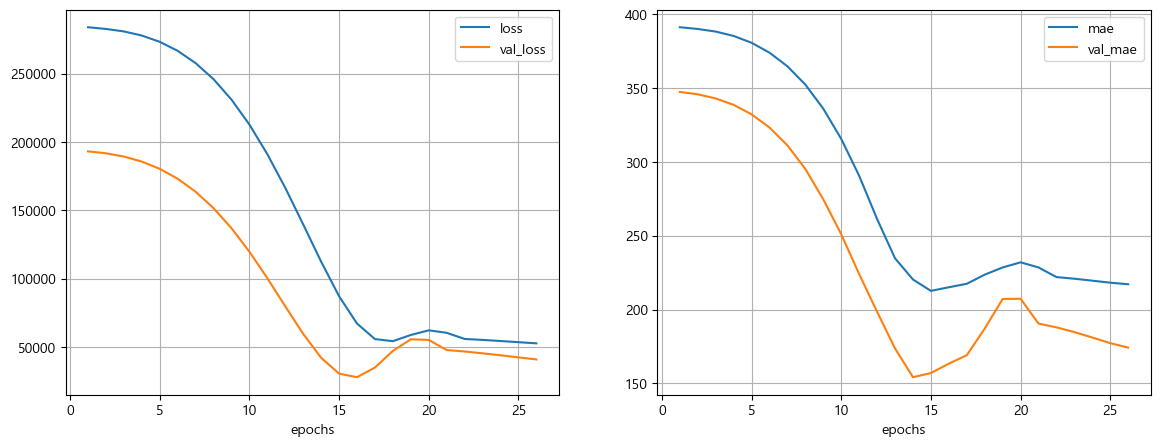

In [11]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train ,x_test, y_test)
tf_result(result)